🚀 **Avance 3. Baseline**: Establecer las medidas de calidad del modelo de aprendizaje automático, Proporcionar un marco de referencia para evaluar y mejorar modelos más avanzados.

📑 **Asignatura**: Proyecto Integrador

📘 **Proyecto**: LunchForecast AI: Optimizador de reservas de almuerzos empresariales basado en inteligencia artificial.

📚 **Equipo**: 44

🧑 **Alumnos**:

Alberto José García Porras (Matrícula No. **A01793509**)

Erick Johan Najera Olivero (Matrícula No. **A01793506**)

Carlos Julio León Caicedo (Matrícula No. **A01793947**)

👩 **Profesores**:

Dra. Grettel Barceló Alonso

Dr. Luis Eduardo Falcón Morales

Dr. Guillermo Mota

📅 Mayo 17 del 2024

In [222]:
#Importamos las librerías que utilizaremos para la ejecución de la actividad
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import numpy as np
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


👣**Obtener Datos**: Cargamos el archivo CSV con la información del consumo del casino desde enero del 2021 hasta marzo del 2024.

In [223]:
dfCasinoConsumo = pd.read_csv("DatosConsumoCasino.csv",sep=";")
dfCasinoConsumoOriginal = dfCasinoConsumo
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1


In [224]:
# Convierte la columna 'fecha del consumo' a tipo datetime si aún no lo está
dfCasinoConsumo['Fecha Consumo'] = pd.to_datetime(dfCasinoConsumo['Fecha Consumo'], format='%Y-%m-%d', errors='coerce')
#dfCasinoConsumo = dfCasinoConsumo.set_index('Fecha Consumo')
dfCasinoConsumo.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1


In [225]:
#Eliminamos las columnas que no consideramos relevantes según hallazgos en la fase de exploración
dfCasinoConsumo=dfCasinoConsumo.drop(columns=['Consecutivo', 'IdProducto', 'cod lector', 'Cod comedor', 'Identificacion persona', 'Invitado','Ing x planta','Nro empleados'])
dfCasinoConsumo.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Fecha Consumo,Detalle,Tipo Empleado,Nivel,Porcentaje apoyo
0,2021-01-03,ALMUERZO,Operativo,OPER,0
1,2021-01-03,ALMUERZO,Administrativo,ANAL,90
2,2021-01-03,ALMUERZO,Operativo,OPER,0
3,2021-01-03,ALMUERZO,Operativo,OPER,90
4,2021-01-03,ALMUERZO,Administrativo,OPER,0


In [226]:

#En el análisis, habíamos notado que existían valores de 'ALMUERZO' en minúsculas en el campo 'DETALLE'
#Por lo anterior, procederemos a pasar a mayúsculas el contenido de la columna antes de proceder con el borrado
dfCasinoConsumo['Detalle'] = dfCasinoConsumo['Detalle'].str.upper()

#Filtramos el dataFrame para conservar solo las filas donde 'DETALLE' es igual a 'ALMUERZO' y lo guardamos en un
#nuevo dataframe para evitar SettingWithCopyWarning
dfCasinoAlmuerzos = dfCasinoConsumo[dfCasinoConsumo['Detalle'] == 'ALMUERZO'].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [227]:
#Creamos un nuevo dataframe para eliminar la fila mencionada
dfAlmuerzosDepurados = dfCasinoAlmuerzos.drop(dfCasinoAlmuerzos[dfCasinoAlmuerzos['Nivel'] == '#N/D'].index)


In [228]:
#Procedemos a realizar la codificación de las columnas categóricas
dfCasinoAlmuerzosCodificado = pd.get_dummies(dfAlmuerzosDepurados, columns=['Tipo Empleado', 'Nivel', 'Porcentaje apoyo'])
dfCasinoAlmuerzosCodificado.head()

,Fecha Consumo,Detalle,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Nivel_ANAL,Nivel_ASIS,Nivel_AUXI,Nivel_COOR,Nivel_DIRE,Nivel_GERE,Nivel_JEFE,Nivel_OPER,Nivel_SENA,Nivel_VICE,Nivel_coor,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,ALMUERZO,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
1,2021-01-03,ALMUERZO,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,2021-01-03,ALMUERZO,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
3,2021-01-03,ALMUERZO,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
4,2021-01-03,ALMUERZO,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False


In [229]:
#Para que el modelo que desarrollaremos más adelante funcione de una mejor manera,
#procederemos a convertir los valores booleanos a números.
#Recorremos todas las columnas y al identificar una booleana, la convertiremos en número.
for col in dfCasinoAlmuerzosCodificado.columns:
    if dfCasinoAlmuerzosCodificado[col].dtype == bool:
        dfCasinoAlmuerzosCodificado[col] = dfCasinoAlmuerzosCodificado[col].astype(int)

dfCasinoAlmuerzosCodificado.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Fecha Consumo,Detalle,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Nivel_ANAL,Nivel_ASIS,Nivel_AUXI,Nivel_COOR,Nivel_DIRE,Nivel_GERE,Nivel_JEFE,Nivel_OPER,Nivel_SENA,Nivel_VICE,Nivel_coor,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,ALMUERZO,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,2021-01-03,ALMUERZO,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2021-01-03,ALMUERZO,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,2021-01-03,ALMUERZO,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2021-01-03,ALMUERZO,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [230]:
#Ajustamos la fecha tipo datetime como preparación para realizar el agrupamiento de los datos
dfCasinoAlmuerzosCodificado['Fecha Consumo'] = pd.to_datetime(dfCasinoAlmuerzosCodificado['Fecha Consumo'])

#Calculamos la cantidad de almuerzos por fecha y las otras columnas categóricas del dataframe
dfCantidad_Almuerzos = dfCasinoAlmuerzosCodificado.groupby(['Fecha Consumo'] + list(dfCasinoAlmuerzosCodificado.columns.difference(['Fecha Consumo', 'Detalle']))).size().reset_index(name='Cantidad_Almuerzos')

#Fusionamos el dataframe que venimos trabajando con el dataframe de la cantidad de almuerzos, eliminando posibles registros duplicados
dfCasinoAlmuerzosAgrupado = pd.merge(dfCasinoAlmuerzosCodificado, dfCantidad_Almuerzos.drop_duplicates(), on=['Fecha Consumo'] + list(dfCasinoAlmuerzosCodificado.columns.difference(['Fecha Consumo', 'Detalle'])), how='left')

dfCasinoAlmuerzosAgrupado

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Fecha Consumo,Detalle,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Nivel_ANAL,Nivel_ASIS,Nivel_AUXI,Nivel_COOR,Nivel_DIRE,...,Nivel_JEFE,Nivel_OPER,Nivel_SENA,Nivel_VICE,Nivel_coor,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100,Cantidad_Almuerzos
0,2021-01-03,ALMUERZO,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,45
1,2021-01-03,ALMUERZO,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3
2,2021-01-03,ALMUERZO,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,45
3,2021-01-03,ALMUERZO,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,75
4,2021-01-03,ALMUERZO,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523879,2024-03-20,ALMUERZO,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,47
523880,2024-03-21,ALMUERZO,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,49
523881,2024-03-22,ALMUERZO,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,40
523882,2024-03-26,ALMUERZO,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,33


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


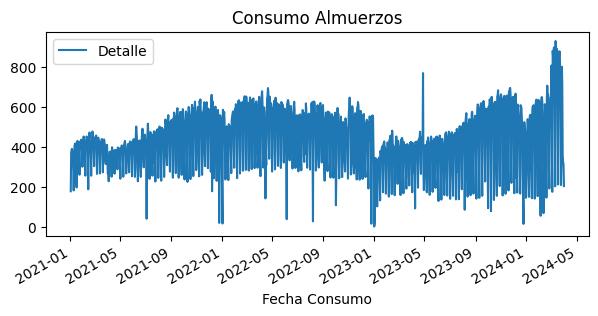

In [231]:
#visualización de la serie vs total de almuerzos
grouped = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').agg({ 'Detalle': 'count'})

fig, ax=plt.subplots(figsize=(7, 3))
grouped.plot(ax=ax, label='Detalle')

ax.set_title('Consumo Almuerzos')
ax.legend();


In [235]:
datos = dfCasinoAlmuerzosCodificado[['Fecha Consumo', 'Detalle']]
#datos = datos.rename(columns={'Fecha Consumo':'date', 'Detalle':'Consumo'})
datos['Fecha Consumo'] = pd.to_datetime(datos['Fecha Consumo'], format='%Y-%m-%d')
datos = datos.set_index('Fecha Consumo')
datos = datos.loc[:'2024-03-30 00:00:00']
#datos = datos.asfreq('MS')
#datos = datos['Consumo']
#datos.columns = ['Fecha Consumo','Consumo']
display(datos.head(4))

<ipython-input-235-08dfc9e4f63f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['Fecha Consumo'] = pd.to_datetime(datos['Fecha Consumo'], format='%Y-%m-%d')


,Detalle
Fecha Consumo,
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO


In [236]:
dfCasinoAlmuerzosCodificado = datos
#dfCasinoAlmuerzosCodificado = dfCasinoAlmuerzosCodificado.set_index('Fecha Consumo')
#dfCasinoAlmuerzosCodificado = dfCasinoAlmuerzosCodificado['Detalle']
# Fechas Train-test
# ======================================================================================
fin_train = '2023-09-30'
print(
    f"Fechas train : {dfCasinoAlmuerzosCodificado.index.min()} --- {dfCasinoAlmuerzosCodificado.loc[:fin_train].index.max()}  "
    f"(n={len(dfCasinoAlmuerzosCodificado.loc[:fin_train])})"
)
print(
    f"Fechas test  : {dfCasinoAlmuerzosCodificado.loc[fin_train:].index.min()} --- {dfCasinoAlmuerzosCodificado.loc[:].index.max()}  "
    f"(n={len(dfCasinoAlmuerzosCodificado.loc[fin_train:])})"
)
datos_train = dfCasinoAlmuerzosCodificado.loc[:fin_train]
datos_test  = dfCasinoAlmuerzosCodificado.loc[fin_train:]



Fechas train : 2021-01-03 00:00:00 --- 2023-09-30 00:00:00  (n=431617)
Fechas test  : 2023-09-30 00:00:00 --- 2024-03-30 00:00:00  (n=92402)


In [237]:
#grouped_train = datos_train.groupby('Fecha Consumo').agg({ 'Detalle': 'count'})
#grouped_test = datos_test.groupby('Fecha Consumo').agg({ 'Detalle': 'count'})
#grouped_train = datos_train.groupby('date').agg({ 'Consumo': 'count'})
#grouped_test = datos_test.groupby('date').agg({ 'Consumo': 'count'})
datos_train

,Detalle
Fecha Consumo,
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO
2021-01-03,ALMUERZO
...,...
2022-12-21,ALMUERZO
2022-12-22,ALMUERZO
2022-12-23,ALMUERZO


In [238]:
grouped_train = datos_train.groupby('Fecha Consumo')['Detalle'].count()
grouped_test = datos_test.groupby('Fecha Consumo')['Detalle'].count()

In [239]:
grouped_train

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fecha Consumo
2021-01-03    178
2021-01-04    370
2021-01-05    386
2021-01-06    391
2021-01-07    377
             ... 
2023-09-26    569
2023-09-27    566
2023-09-28    592
2023-09-29    555
2023-09-30    339
Name: Detalle, Length: 999, dtype: int64

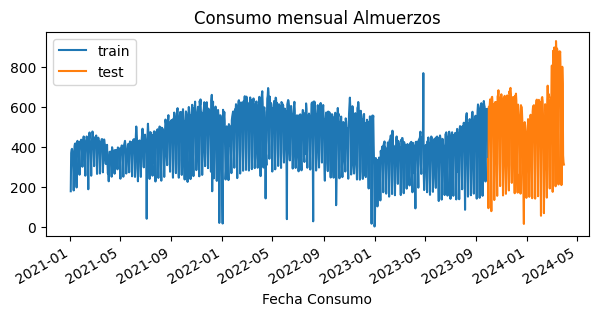

In [240]:
# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
grouped_train.plot(ax=ax, label='train')
grouped_test.plot(ax=ax, label='test')
ax.set_title('Consumo mensual Almuerzos')
ax.legend();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test estacionariedad serie original
-------------------------------------
ADF Statistic: -3.4731656202966716, p-value: 0.008703602748095377
KPSS Statistic: 1.1755548738439585, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -10.316328232064834, p-value: 3.0904357865978174e-18
KPSS Statistic: 0.07477478068387071, p-value: 0.1


<Axes: title={'center': 'Diferenciación orden 1'}, xlabel='Fecha Consumo'>

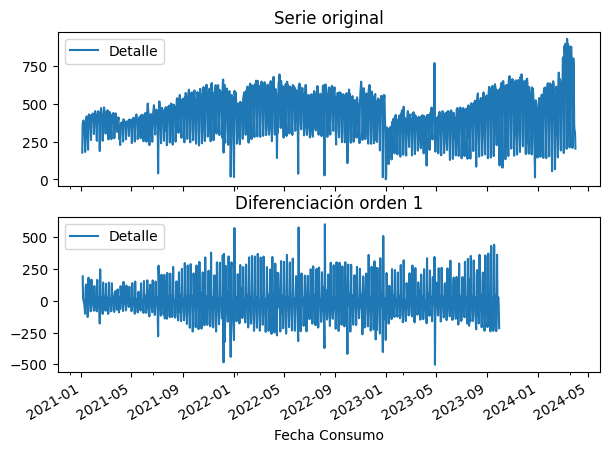

In [123]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = grouped_train.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(grouped)
kpss_result = kpss(grouped)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(grouped.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
grouped.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')


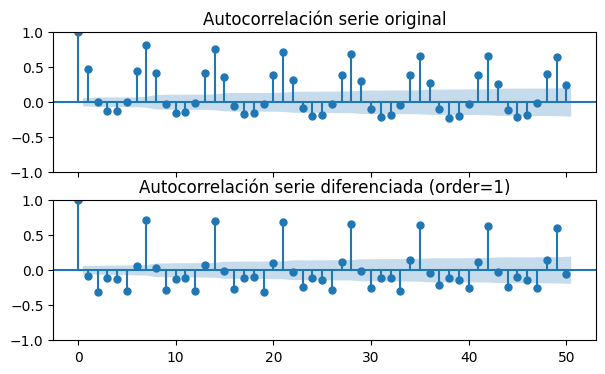

In [124]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(grouped, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

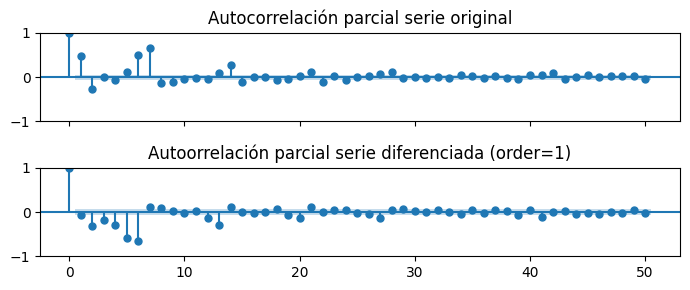

In [125]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(grouped, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();


☝  **¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?**


In [241]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = grouped_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Detalle   No. Observations:                  999
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6128.223
Date:                            Sat, 18 May 2024   AIC                          12266.447
Time:                                    21:20:18   BIC                          12290.915
Sample:                                         0   HQIC                         12275.753
                                            - 999                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5254      0.024     21.559      0.000       0.478       0.573
ma.L1         -0.9998      0.025    -39.353      0.000      -1.050      -0.950
ar.S.L12      -0.2050      0.035     -5.929      0.000      -0.273      -0.137
ma.S.L12      -0.9998      3.386     -0.295      0.768      -7.636       5.636
sigma2      1.366e+04   4.59e+04      0.297      0.766   -7.64e+04    1.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.19   Jarque-Bera (JB):                25.20
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [242]:
# Predicciones
pred = modelo_res.get_prediction(start=0, end=len(grouped_train)-1)
pred_mean = pred.predicted_mean

# Calcular métricas
mse = mean_squared_error(grouped_train, pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(grouped_train, pred_mean)
mape = np.mean(np.abs((grouped_train - pred_mean) / grouped_train)) * 100
r2 = r2_score(grouped_train, pred_mean)
aic = modelo_res.aic
bic = modelo_res.bic

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

MSE: 14293.02284928066
RMSE: 119.55343093897665
MAE: 91.39936536720289
MAPE: 79.20182049688381
R²: 0.2017671947989721
AIC: 12266.44680359833
BIC: 12290.915085371344


In [243]:
#grouped_test['Fecha Consumo'] = pd.to_datetime(grouped_test['Fecha Consumo'])
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(grouped_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


999     368.060522
1000    370.159771
1001    390.645452
1002    376.589000
Name: predicciones_statsmodels, dtype: float64

In [75]:
grouped_test.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Detalle
Fecha Consumo,
2023-09-30,339
2023-10-01,93
2023-10-02,602
2023-10-03,603
2023-10-04,604


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


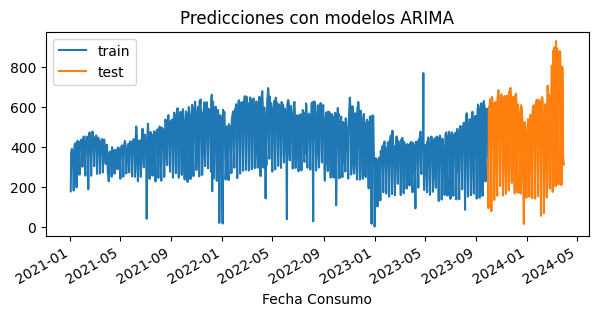

In [245]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
grouped_train.plot(ax=ax, label='train')
grouped_test.plot(ax=ax, label='test')
#predicciones_statsmodels.plot(ax=ax, label='statsmodels')
#predicciones_skforecast.columns = ['skforecast']
#predicciones_skforecast.plot(ax=ax, label='skforecast')
#predicciones_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predicciones con modelos ARIMA')
ax.legend();